In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, roc_auc_score
import torch
import ast 
import seaborn as sns
import numpy as np
import joblib
import pandas as pd
import pickle


### Data used:

In [2]:
# pre-processed version of original data
original_data_test = pd.read_csv('data/twitter_data/cleaned_tweet_test.csv')

# new dataset
new_data_test = pd.read_csv('data/twitter_data/new_tweet_data_clean.csv')

In [3]:
y_test_original = original_data_test['label']
y_test_new = new_data_test['label']

# This notebook contains all results 

## Result for the baseline model

In [8]:
# load baseline model 
LR_model = joblib.load('saved_models/LR_model.pkl')
# load predictions
LR_pred = joblib.load('saved_models/LR_predictions.pkl')
LR_pred_new = joblib.load('saved_models/LR_predictions_new.pkl')

In [11]:
print("AUC score (original): ", roc_auc_score(y_test_original, LR_pred))
print("Accuracy (original): ", accuracy_score(y_test_original, LR_pred))

print("AUC score (new): ", roc_auc_score(y_test_new, LR_pred_new))
print("Accuracy (new): ", accuracy_score(y_test_new, LR_pred_new))

AUC score (original):  0.8058879445314246
Accuracy (original):  0.805607476635514
AUC score (new):  0.7697676232064878
Accuracy (new):  0.8585807750377453


## Results for the LSTM model

In [8]:
num_epochs = 50
# load models
LSTM_pred = joblib.load('saved_models/test_y_pred_original.pkl')
# round predictions
LSTM_pred = np.round(LSTM_pred)
LSTM_pred_new = joblib.load('saved_models/test_y_pred_new.pkl')
# round predictions
LSTM_pred_new = np.round(LSTM_pred_new)

In [10]:
print("AUC score (original): ", roc_auc_score(y_test_original, LSTM_pred))
print("Accuracy (original): ", accuracy_score(y_test_original, LSTM_pred))

print("AUC score (original): ", roc_auc_score(y_test_new, LSTM_pred_new))
print("Accuracy (new): ", accuracy_score(y_test_new, LSTM_pred_new))

AUC score (original):  0.48966487735778724
Accuracy (original):  0.48909657320872274
AUC score (original):  0.5257825496464961
Accuracy (new):  0.33870156014091596


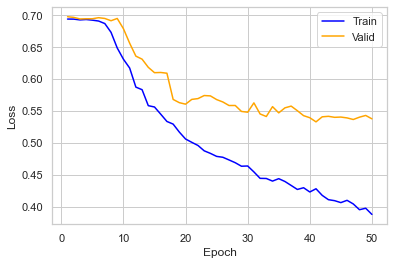

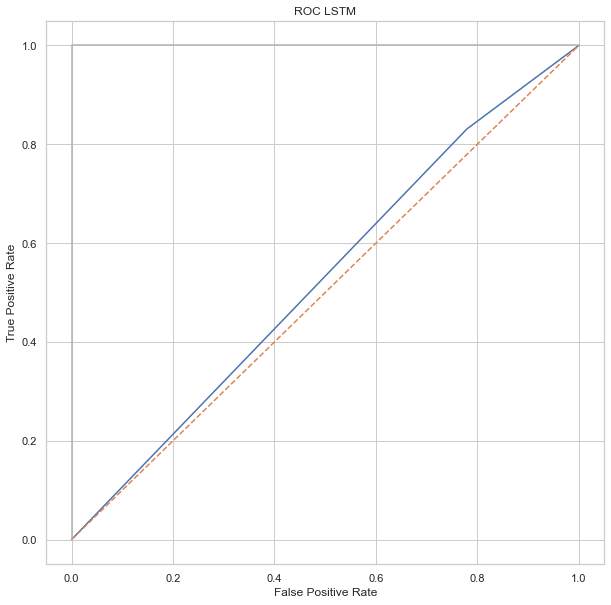

In [12]:
# %%
# load train and valdiation loss
train_loss_list = joblib.load('saved_models/train_loss_original.pkl')
valid_loss_list = joblib.load('saved_models/valid_loss_new.pkl')
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
sns.lineplot(x=np.arange(1,num_epochs+1), y=train_loss_list, color='blue', label='Train');
sns.lineplot(x=np.arange(1, num_epochs + 1), y=valid_loss_list, color='orange', label='Valid');
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.show()
#plt.savefig("50epochs_cleaned.png")

# Roc curve
fpr, tpr, threshold = roc_curve(y_test_new, LSTM_pred_new)

# print(fpr,tpr)

# plt.subplots(1, figsize=(10,10))
# plt.title('ROC LSTM')
# plt.plot(fpr, tpr)
# plt.plot([0, 1], ls="--")
# plt.plot([0, 0], [1, 0] , c=".7")
# plt.plot([1, 1] , c=".7")
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()
#plt.savefig("50-epochs-roc-cleaned")


## Results for the BERT model

In [ ]:
# Load data for model
import pandas as pd
from transformers import AutoModelForSequenceClassification, Trainer, AutoTokenizer
from datasets import load_dataset


##### Load data for unbalanced dataset
d_a = pd.read_csv("data/twitter_data/new_tweet_dataset_train.csv")
d_a = d_a.rename(columns={'tweet_text':'Tweet'})
d_a['billed'] = d_a['Tweet'].apply(lambda x: 1 if 'http' in x else 0)
d_a_ub = d_a[d_a['billed']==0]
d_a_ub[["Tweet","label"]].to_csv("data/twitter_data/new_tweet_train.csv",index=False)

data_files = {"train": "data/twitter_data/new_tweet_train.csv"}
dataset = load_dataset("csv", data_files=data_files)

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_function(examples):
    return tokenizer(examples["Tweet"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

##### Load data for balanced dataset (only for new prediction, old predictions are saved)
# from datasets import load_from_disk
# tokenized_balanced = load_from_disk("src/data/tokenized_data")


In [ ]:
# Make new predictions by loading pretrained model and tokenizer 

# Load Tokenizer and model for predicting
model = AutoModelForSequenceClassification.from_pretrained(
             "src/bert_models/trained_bert_3", num_labels=2)
trainer = Trainer(model)

#### Prediction unbalanced
testset_unblanced = tokenized_datasets["Test"]#.select(range(200))
predictions_unb, labels_unb, _, = trainer.predict(testset_unblanced)

#### Prediction balanced
# testset_blanced   = tokenized_balanced["Test"]#.select(range(200))
# predictions_b, labels_b, _, = trainer.predict(testset_blanced)
        # Load earlier prediction for balanced dataset
predictions_b = np.load('src/data/PredictedTestData/PredictionTestData.npy')
labels_b      = np.load('src/data/PredictedTestData/Labels.npy')

#### evaluate - Accuracy
# metric = evaluate.load("accuracy")
# print(metric.compute(predictions_b=np.argmax(predictions_b,-1), references=labels_b))

#### Save predictions
# np.save('src/data/PredictedTestData/PredictionTestData',predictions_b)
# np.save('src/data/PredictedTestData/Labels',labels_b)

In [ ]:
# Get accuracy and examples
#accuarcy
acc_unb = np.sum(np.argmax(predictions_unb,axis=-1)==labels_unb)/200
acc_b   = np.sum(np.argmax(predictions_b,axis=-1)==labels_b)/200

#examples
print(testset_unblanced['Tweet'][:2], testset_unblanced['Tweet'][175],testset_unblanced['Tweet'][45])

In [ ]:
# ROC curve for balanced dataset
exppred = np.exp(predictions_b)
predsoft = exppred/np.sum(exppred)
predsoft /= np.max(predsoft)
ratio = np.c_[[(predsoft[:,1]>i) for i in np.linspace(0.01,0.95,1000)]]

TP = np.sum((labels_b==ratio)[:,labels_b==1], 1)
TN = np.sum((labels_b==ratio)[:,labels_b==0], 1)
FP = np.sum((labels_b!=ratio)[:,labels_b==0], 1) 
FN = np.sum((labels_b!=ratio)[:,labels_b==1], 1)

TPR = TP/(TP+FN) # Recall/sensitivity
FPR = FP/(FP+TN)

# AUC score
auc(FPR, TPR)

# Visualization
plt.subplots(1, figsize=(10,10))
plt.title('ROC BERT')
plt.plot(FPR, TPR)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("50-epochs-roc")

In [ ]:
# Training and validation loss

# load data from output file
output = []
for i in ['Output_14988963']:
    with open(f'src/log/{i}.out') as f:
        output.append(np.array(f.readlines())[1:])
messagedict =  [list(map(ast.literal_eval,run)) for run in output]

mapp = lambda x: [[epoch[x] for epoch in run if x in epoch] for run in messagedict]
eval_loss=mapp('eval_loss');eval_accu=mapp('eval_accuracy');train_loss=mapp('loss') 

# visualize train and validation loss
num_epochs = 10
train_loss_ = np.array(train_loss[0])[np.linspace(0,len(train_loss[0])-1,10).astype(int)]
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
sns.lineplot(x=np.arange(1,num_epochs+1), y=train_loss_, color='blue', label='Train');
sns.lineplot(x=np.arange(1, num_epochs + 1), y=eval_loss[0], color='orange', label='Valid');
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("test.png")
